In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [2]:
from hyperopt import fmin # responsible for minimizing the objective function
from hyperopt import tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, mean_squared_error, r2_score, mean_absolute_error

import mlflow

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
#import xgboost as xgb
# lets try other classification models and see
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

In [4]:
# get the training and test datasets
X_train_df = pd.read_csv('C:\\Users\\Cash Crusaders\\Desktop\\My Portfolio\\Projects\\Data Science Projects\\Machine Learning Project 11 - Car Price Prediction\\dataset\\X_train.csv')
X_test_df=pd.read_csv('C:\\Users\\Cash Crusaders\\Desktop\\My Portfolio\\Projects\\Data Science Projects\\Machine Learning Project 11 - Car Price Prediction\\dataset\\X_test_df.csv')
y_train_df=pd.read_csv('C:\\Users\\Cash Crusaders\\Desktop\\My Portfolio\\Projects\\Data Science Projects\\Machine Learning Project 11 - Car Price Prediction\\dataset\\y_train_df.csv')
y_test_df=pd.read_csv('C:\\Users\\Cash Crusaders\\Desktop\\My Portfolio\\Projects\\Data Science Projects\\Machine Learning Project 11 - Car Price Prediction\\dataset\\y_test_df.csv')
# load standard scaler
sc = None
scaler_path = os.path.join('C:\\Users\\Cash Crusaders\\Desktop\\My Portfolio\\Projects\\Data Science Projects\\Machine Learning Project 11 - Car Price Prediction\\dataset\\standard_scaler.pkl')
filename = 'C:\\Users\\Cash Crusaders\\Desktop\\My Portfolio\\Projects\\Data Science Projects\\Machine Learning Project 11 - Car Price Prediction\\dataset\\standard_scaler.pkl'

In [27]:
with open(filename, 'rb') as f:
    sc = pickle.load(f)

EOFError: Ran out of input

In [32]:
file = open('C:\\Users\\Cash Crusaders\\Desktop\\My Portfolio\\Projects\\Data Science Projects\\Machine Learning Project 11 - Car Price Prediction\\dataset\\standard_scaler.pkl', 'rb')
pickle.load(file)

EOFError: Ran out of input

In [5]:
y_test_df.head()

,Unnamed: 0,Price
0,656,510000.0
1,397,650000.0
2,304,498000.0
3,85,189500.0
4,60,150000.0


In [6]:
X_train_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
y_train_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
#test set
X_test_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
y_test_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [7]:
y_train_df.head()

,Price
0,398132.709877
1,398132.709877
2,135000.000000
3,465000.000000
4,68000.000000


In [8]:
# change the pandas datasets to numpy arrays
X_train = np.asarray(X_train_df)
X_test = np.asarray(X_test_df)
y_train = np.asarray(y_train_df)
y_test = np.asarray(y_test_df)

In [9]:
type(y_train)

numpy.ndarray

In [10]:
#set the tracking uri - needed for the ssqlite 
mlflow.set_tracking_uri("sqlite:///car-price.db")
#set the experiment
mlflow.set_experiment("car-price-experiment-1")

2023/01/31 18:41:06 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/01/31 18:41:08 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='./mlruns/1', creation_time=1675183281677, experiment_id='1', last_update_time=1675183281677, lifecycle_stage='active', name='car-price-experiment-1', tags={}>

In [11]:
linSVR = LinearSVR()
mult_lin = LinearRegression()
svr = SVR(kernel = 'rbf')
knn_reg = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
rft = RandomForestRegressor()
abr = AdaBoostRegressor()
br = BaggingRegressor()
etr = ExtraTreesRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()
poly_reg = PolynomialFeatures(degree = 4)



In [ ]:
X_train_poly = poly_reg.fit_transform(X_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_train_poly, y_train)

In [12]:
# fit all the models using the training data
def train_regressor_model(reg,X_train,y_train,X_test,y_test):
  reg.fit(X_train,y_train.ravel())
  y_pred = reg.predict(X_test)
  r2 = r2_score(y_test,y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)

  return r2, mse, mae

In [13]:
reg_dict = {
    'lin_SVR': linSVR,
    'SVR': svr,
    'KNN_reg': knn_reg,
    'DTR': dtr,
    'RFT':rft,
    'AdaBR':abr,
    'BagR':br,
    'ExtaTR':etr,
    'GradientBR':gbr,
    'XtremeGB':xgb
}

In [14]:
# list that will contain the scores
r2_list =[]
mse_list =[]
mae_list = []

# fitting all the models
for name,reg in reg_dict.items():
  cur_r2, cur_mse, cur_mae = train_regressor_model(reg,X_train,y_train,X_test, y_test)
  print("For : ", name)
  print("R2 = ",cur_r2)
  print("MSE = ",cur_mse)
  print("MAE = ",cur_mae)
  print('**************')
  r2_list.append(cur_r2)
  mse_list.append(cur_mse)
  mae_list.append(cur_mae)

For :  lin_SVR
R2 =  -1.45125081955069
MSE =  201697210670.06934
MAE =  345563.0585037774
**************
For :  SVR
R2 =  -0.025763535737299392
MSE =  84403294152.98453
MAE =  188059.67511009562
**************
For :  KNN_reg
R2 =  0.3068432425436013
MSE =  57035283138.300766
MAE =  153329.76850930534
**************
For :  DTR
R2 =  -0.22297712502852418
MSE =  100630695506.21031
MAE =  159234.40081997422
**************
For :  RFT
R2 =  0.43300256933134984
MSE =  46654466899.44405
MAE =  127393.66945774214
**************
For :  AdaBR
R2 =  -0.46971049106216345
MSE =  120932751628.4574
MAE =  274256.2629917235
**************
For :  BagR
R2 =  0.4476741617329856
MSE =  45447238638.71448
MAE =  122476.27797586143
**************
For :  ExtaTR
R2 =  0.643182408804039
MSE =  29360158612.993443
MAE =  113773.79539639765
**************
For :  GradientBR
R2 =  0.4435073871391083
MSE =  45790094949.612114
MAE =  139293.5317724583
**************
For :  XtremeGB
R2 =  -0.07163198980976526
MSE =  881

In [15]:
performance_df = pd.DataFrame({'Algorithm':reg_dict.keys(),'R2 Score':r2_list,'MSE':mse_list, 'MAE':mae_list}).sort_values('R2 Score',ascending=False)

In [16]:
performance_df

,Algorithm,R2 Score,MSE,MAE
7,ExtaTR,0.643182,2.936016e+10,113773.795396
6,BagR,0.447674,4.544724e+10,122476.277976
8,GradientBR,0.443507,4.579009e+10,139293.531772
4,RFT,0.433003,4.665447e+10,127393.669458
2,KNN_reg,0.306843,5.703528e+10,153329.768509
1,SVR,-0.025764,8.440329e+10,188059.675110
9,XtremeGB,-0.071632,8.817751e+10,143376.893643
3,DTR,-0.222977,1.006307e+11,159234.400820
5,AdaBR,-0.469710,1.209328e+11,274256.262992
0,lin_SVR,-1.451251,2.016972e+11,345563.058504


In [17]:
performance_df1 = pd.melt(performance_df, id_vars="Algorithm")

In [18]:
performance_df1

,Algorithm,variable,value
0,ExtaTR,R2 Score,6.431824e-01
1,BagR,R2 Score,4.476742e-01
2,GradientBR,R2 Score,4.435074e-01
3,RFT,R2 Score,4.330026e-01
4,KNN_reg,R2 Score,3.068432e-01
5,SVR,R2 Score,-2.576354e-02
6,XtremeGB,R2 Score,-7.163199e-02
7,DTR,R2 Score,-2.229771e-01
8,AdaBR,R2 Score,-4.697105e-01
9,lin_SVR,R2 Score,-1.451251e+00


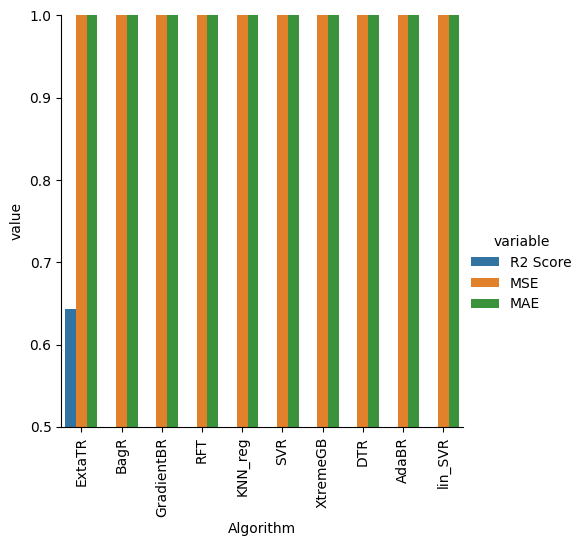

In [19]:
# plot the results
sns.catplot(x='Algorithm', y='value', hue ='variable', data=performance_df1, kind='bar', height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# try the ANN and see its performance
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

In [ ]:
y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    '''define the objective function that will take in different arguments
     and fit them, return the loss for each experiment run'''
    with mlflow.start_run(): # start the run
        mlflow.set_tag("model", "xgboost") # tag to know which is  this module doing the run
        mlflow.log_params(params) # logging the parameters
        # fit/train the xgboost model
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    # return the loss for this run 
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
# search space to search for different values that will optimize the objective function and reduce the rsme
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}
# use the fmin built-in function to get the best results from the search of the obj function
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [ ]:
# trying to log parameters and model artifact automatically
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    # convert the data to DMatrix so they fit the  xgboost
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)
    # the best parameters that minimize the rsme and optimize the objective function, taken from mlflow
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }
    # log the parameters on mlflow
    mlflow.log_params(best_params)
    # now train the model with the best parames chosen from the run that performed better thann others
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    # saving the perprocessing tool we used wihc is the dictionary vectorizer
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    # logging it into the mlflow
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    # logging the model artifact
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
# triggering mlflow to activate the auto log function 
mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        